In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)

13574144/13568290 [==============================] - 1s 0us/step


In [3]:
csv_path, _ = os.path.splitext(zip_path)

In [4]:
csv_path

'/root/.keras/datasets/jena_climate_2009_2016.csv'

In [5]:
df = pd.read_csv(csv_path)

In [6]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
p (mbar),420551.0,989.212776,8.358481,913.60,984.20,989.58,994.72,1015.35
T (degC),420551.0,9.450147,8.423365,-23.01,3.36,9.42,15.47,37.28
Tpot (K),420551.0,283.492743,8.504471,250.60,277.43,283.47,289.53,311.34
Tdew (degC),420551.0,4.955854,6.730674,-25.01,0.24,5.22,10.07,23.11
rh (%),420551.0,76.008259,16.476175,12.95,65.21,79.30,89.40,100.00
VPmax (mbar),420551.0,13.576251,7.739020,0.95,7.78,11.82,17.60,63.77
VPact (mbar),420551.0,9.533756,4.184164,0.79,6.21,8.86,12.35,28.32
VPdef (mbar),420551.0,4.042412,4.896851,0.00,0.87,2.19,5.30,46.01
sh (g/kg),420551.0,6.022408,2.656139,0.50,3.92,5.59,7.80,18.13
H2OC (mmol/mol),420551.0,9.640223,4.235395,0.80,6.29,8.96,12.49,28.82


In [8]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [9]:
TRAIN_SPLIT = 300000

In [10]:
tf.random.set_seed(13)

In [11]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.columns = ['T (degC)']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

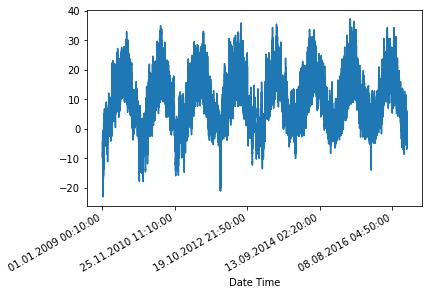

In [13]:
uni_data.plot(subplots=True)
plt.show()

In [14]:
uni_data = uni_data.values 

In [15]:
uni_data

array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82])

In [16]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std

In [17]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [18]:
print ('Ventana  de la historia pasada')
print (x_train_uni[1])
print ('\n Temperature objetivo (target) para predecir')
print (y_train_uni[1])

Ventana  de la historia pasada
[[-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]
 [-2.10418486]]

 Temperature objetivo (target) para predecir
-2.0949220845536356


In [19]:
def create_time_steps(length):
  return list(range(-length, 0))

In [20]:
def show_plot(plot_data, delta, title):
  labels = ['Historia', 'Futuro Verdadero' , 'Predicción del Modelo']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Salto de tiempo (Time-Step)')
  return plt

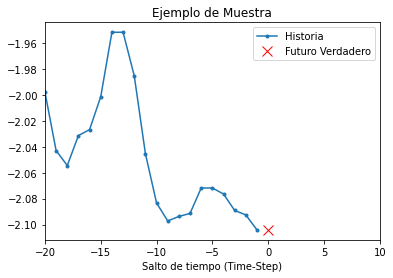

In [21]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Ejemplo de Muestra')
plt.show()

In [22]:
def baseline(history):
  return np.mean(history)

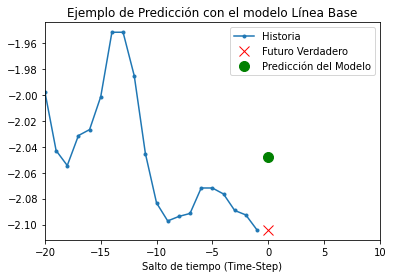

In [23]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Ejemplo de Predicción con el modelo Línea Base')
plt.show()

In [24]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [25]:
simple_lstm_model = tf.keras.models.Sequential()
simple_lstm_model.add(tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]))
simple_lstm_model.add(tf.keras.layers.Dense(1))

In [26]:
simple_lstm_model.compile(optimizer='adam', loss='mae')

In [27]:
simple_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [28]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

history = simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 1s 6ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.1118 - val_loss: 0.0360
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0490 - val_loss: 0.0289
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0443 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0317 - val_loss: 0.0226
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0287 - val_loss: 0.0206
Epoch 8/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0263 - val_loss: 0.0199
Epoch 9/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0254 - val_loss: 0.0182
Epoch 10/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0228 - val_loss: 0.0173

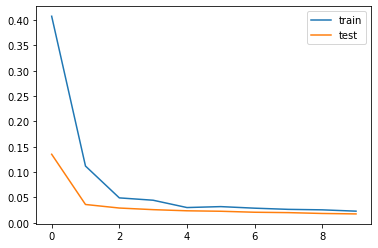

In [29]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

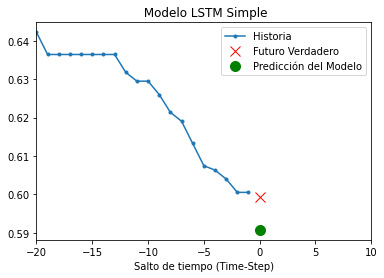

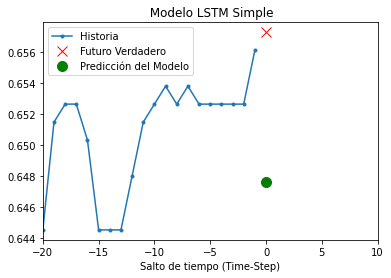

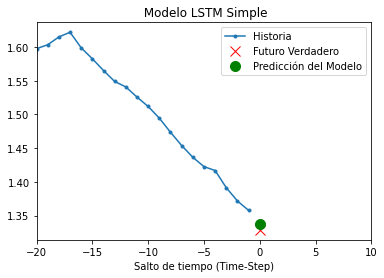

In [30]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, ' Modelo LSTM Simple')
  plot.show()

In [31]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [32]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


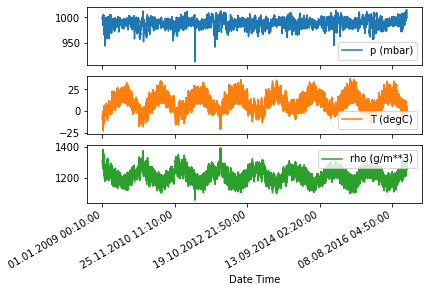

In [33]:
features.plot(subplots=True)
plot.show()

In [34]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [35]:
dataset = (dataset-data_mean)/data_std

In [36]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [38]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [39]:
x_train_single[0:10,:]

array([[[ 0.95547359, -1.99766294,  2.2350791 ],
        [ 0.95304508, -1.95134907,  2.18442875],
        [ 0.96883036, -2.09376424,  2.34176293],
        ...,
        [ 0.9627591 , -2.26396773,  2.52919369],
        [ 1.0186147 , -2.3125973 ,  2.59672749],
        [ 1.06475628, -2.45385463,  2.76164698]],

       [[ 0.96154485, -2.04281897,  2.28524007],
        [ 0.95304508, -1.95134907,  2.18467344],
        [ 0.98218713, -2.09144854,  2.34274168],
        ...,
        [ 0.97854438, -2.27438836,  2.54460901],
        [ 1.02711446, -2.32880716,  2.61654719],
        [ 1.07568454, -2.47701156,  2.78978607]],

       [[ 0.95668784, -2.05439744,  2.29600633],
        [ 0.95304508, -1.98492663,  2.22088721],
        [ 0.9906869 , -2.07176515,  2.32365604],
        ...,
        [ 0.98704414, -2.2778619 ,  2.55097089],
        [ 1.02954297, -2.35312194,  2.64321815],
        [ 1.0793273 , -2.49322142,  2.80813764]],

       ...,

       [[ 0.95304508, -1.95134907,  2.18467344],
        [ 0

In [40]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [41]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

In [42]:
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [43]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [44]:
single_step_model.predict(x).T

array([[0.3111351 , 0.30660602, 0.3011719 , 0.29603297, 0.29335037,
        0.28960344, 0.2852978 , 0.2798868 , 0.27210665, 0.26696068,
        0.2640861 , 0.26190642, 0.25758705, 0.2510705 , 0.24265543,
        0.23777668, 0.23381369, 0.2291645 , 0.22402497, 0.21882285,
        0.21109052, 0.2056046 , 0.20165227, 0.19740395, 0.1943878 ,
        0.19019333, 0.18351783, 0.17847645, 0.17551675, 0.17253059,
        0.1701145 , 0.16636395, 0.16177887, 0.15802597, 0.15534787,
        0.15399738, 0.15198214, 0.15149283, 0.14908698, 0.14706232,
        0.14662907, 0.14746003, 0.14627142, 0.14588465, 0.14473432,
        0.14719774, 0.15193795, 0.1558991 , 0.16007727, 0.17051335,
        0.1786673 , 0.18568572, 0.19290067, 0.19431171, 0.2018993 ,
        0.21648988, 0.22375901, 0.22921436, 0.23576517, 0.24115759,
        0.25011894, 0.26394084, 0.27150372, 0.27826646, 0.28262398,
        0.28709042, 0.29650164, 0.30599746, 0.31115937, 0.3165059 ,
        0.31941512, 0.32305434, 0.33024415, 0.33

In [45]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 0.3090 - val_loss: 0.2646
Epoch 2/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2624 - val_loss: 0.2437
Epoch 3/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2614 - val_loss: 0.2472
Epoch 4/10
200/200 [==============================] - 2s 12ms/step - loss: 0.2567 - val_loss: 0.2445
Epoch 5/10
200/200 [==============================] - 2s 11ms/step - loss: 0.2265 - val_loss: 0.2339
Epoch 6/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2418 - val_loss: 0.2692
Epoch 7/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2415 - val_loss: 0.2556
Epoch 8/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2411 - val_loss: 0.2384
Epoch 9/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2450 - val_loss: 0.2474
Epoch 10/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2387 - val_los

In [46]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

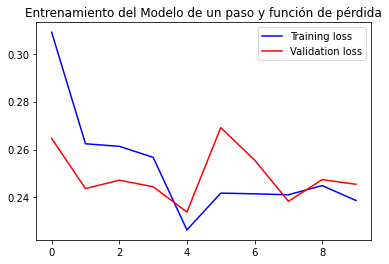

In [47]:
plot_train_history(single_step_history,
                   'Entrenamiento del Modelo de un paso y función de pérdida')

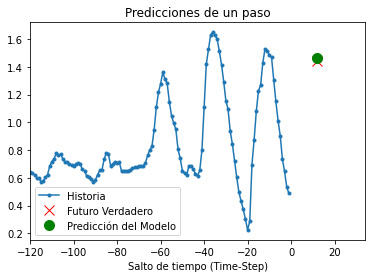

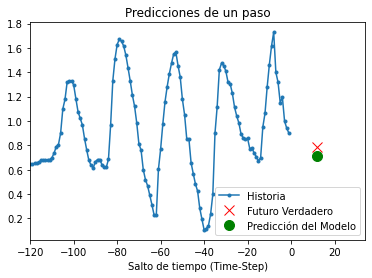

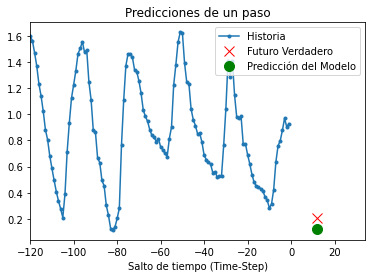

In [48]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Predicciones de un paso')
  plot.show()

In [49]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [50]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [51]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [52]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

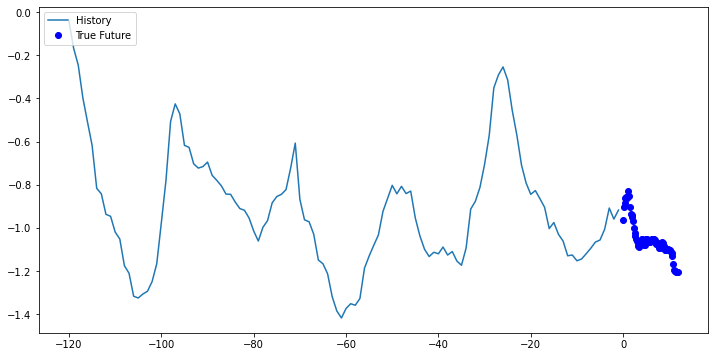

In [53]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

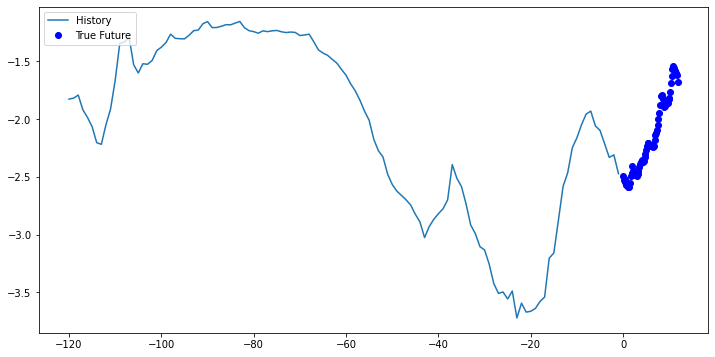

In [54]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))